In [128]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error

In [129]:
df = pd.read_csv("../DBtrainrides_final_result.csv")

In [170]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../utils')))  # Add the parent directory to the path

from utils import fill_missing_times, normalize_dates, ordinal_scaling

In [133]:
message_order = ['No message', 'Information', 'Bauarbeiten', 'Störung', 'Großstörung']
df = ordinal_scaling(df, "transformed_info_message", "label_info_encoded", message_order)
df = normalize_dates(df)

df

,ID_Base,ID_Timestamp,stop_number,IBNR,long,lat,arrival_plan,departure_plan,arrival_delay_m,transformed_info_message,prev_arrival_delay_m,prev_departure_delay_m,weighted_avg_prev_delay,max_station_number,station_progress,label_info_encoded,arrival_normalized,departure_normalized
1210013,-9223176950731764733,2407040400,2,8005613.0,9.250030,53.101242,2024-07-11 04:16:00,2024-07-11 04:16:00,0.0,No message,0.0,0.0,0.0,2,1.00,0,0.455571,0.455571
1210014,-9223176950731764733,2407080400,2,8005613.0,9.250030,53.101242,2024-07-08 04:16:00,2024-07-08 04:16:00,0.0,No message,0.0,0.0,0.0,2,1.00,0,0.028102,0.028102
1210015,-9223176950731764733,2407090400,2,8005613.0,9.250030,53.101242,2024-07-09 04:16:00,2024-07-09 04:16:00,0.0,No message,0.0,0.0,0.0,2,1.00,0,0.170592,0.170592
1210016,-9223176950731764733,2407100400,2,8005613.0,9.250030,53.101242,2024-07-10 04:16:00,2024-07-10 04:16:00,0.0,No message,0.0,0.0,0.0,2,1.00,0,0.313081,0.313081
1210017,-9223176950731764733,2407120400,2,8005613.0,9.250030,53.101242,2024-07-12 04:16:00,2024-07-12 04:16:00,0.0,No message,0.0,0.0,0.0,2,1.00,0,0.598061,0.598061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2417320,9220892137995967708,2407111516,3,8001908.0,7.008821,51.404517,2024-07-11 15:23:00,2024-07-11 15:23:00,0.0,Bauarbeiten,0.0,0.0,0.0,4,0.75,2,0.521571,0.521571
2417321,9220892137995967708,2407111516,4,8001896.0,7.023296,51.422853,2024-07-11 15:26:00,2024-07-11 15:26:00,0.0,Bauarbeiten,0.0,0.0,0.0,4,1.00,2,0.521868,0.521868
2417322,9220892137995967708,2407121516,2,8001915.0,6.997845,51.386828,2024-07-12 15:20:00,2024-07-12 15:20:00,0.0,Information,0.0,0.0,0.0,4,0.50,1,0.663764,0.663764
2417323,9220892137995967708,2407121516,3,8001908.0,7.008821,51.404517,2024-07-12 15:23:00,2024-07-12 15:23:00,0.0,Information,0.0,0.0,0.0,4,0.75,1,0.664061,0.664061


In [134]:
target = df["arrival_delay_m"]
unique_base_ids = df['ID_Base'].unique()
np.random.seed(42)  # For reproducibility, if desired
shuffled_ids = np.random.permutation(unique_base_ids)
split_index = int(0.8 * len(shuffled_ids))

base_ids_80 = shuffled_ids[:split_index]  # 80% of Base_IDs
base_ids_20 = shuffled_ids[split_index:]  # 20% of Base_IDs

# Step 3: Split the dataframe based on the Base_ID sets
X_train = df[df['ID_Base'].isin(base_ids_80)]
X_test = df[df['ID_Base'].isin(base_ids_20)]

y_train = X_train["arrival_delay_m"]
y_test = X_test["arrival_delay_m"] 

X_train = X_train.drop(columns=["arrival_delay_m", "transformed_info_message","arrival_plan","departure_plan"])

X_test = X_test.drop(columns=["arrival_delay_m", "transformed_info_message","arrival_plan","departure_plan"])

In [135]:
regression_tree = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, max_leaf_nodes=10)
# Train on scaled data
regression_tree.fit(X_train, y_train)

# Predict on the test data
y_pred = regression_tree.predict(X_test)

# Calculate Mean Squared Error as a performance metric
mse = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mse)

Mean Absolute Error: 0.8174893341767202


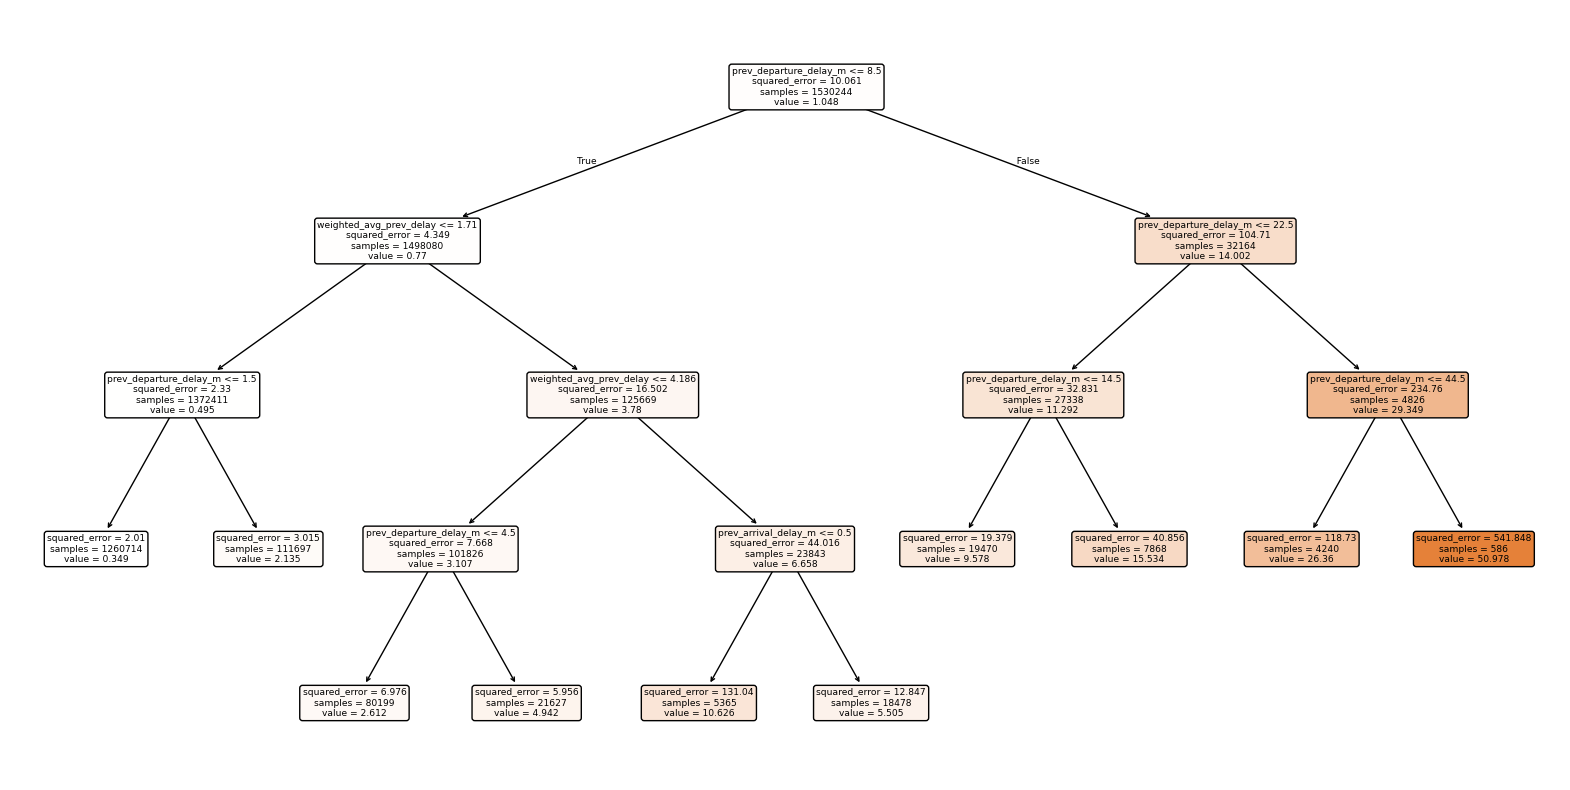

In [136]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assuming 'regressor' is your trained DecisionTreeRegressor
plt.figure(figsize=(20, 10))  # Adjust size as needed for readability
plot_tree(regression_tree, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

In [137]:
regression_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [138]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    "max_leaf_nodes": [10, 20, 15]
}

In [139]:
X, y = df.drop(columns=["arrival_delay_m", "transformed_info_message","arrival_plan","departure_plan"]), df["arrival_delay_m"]

In [163]:
grid_search = GridSearchCV(
    estimator=regression_tree, param_grid=param_grid, cv=5, n_jobs=-1)
 
# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(max_depth=10, max_leaf_nodes=20,
                                             min_samples_split=10),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'max_leaf_nodes': [10, 20, 15],
                         'min_samples_split': [2, 5, 10]})

In [141]:
results = pd.DataFrame(grid_search.cv_results_)

In [142]:
cv_params = results["params"]
cv_mean_test_score = results["mean_test_score"]

In [143]:
param_test_scores = []

In [144]:
for key in cv_params.keys():
    param = str(cv_params[key])
    score = float(cv_mean_test_score[key])
    target = (param, score)
    param_test_scores.append(target)

In [145]:
param_test_scores = sorted(param_test_scores, key=lambda x: x[1], reverse=True)

In [146]:
param_test_scores

[("{'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_split': 2}",
  0.6357291676706962),
 ("{'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_split': 5}",
  0.6357291676706962),
 ("{'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_split': 10}",
  0.6357291676706962),
 ("{'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_split': 2}",
  0.6357291676706962),
 ("{'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_split': 5}",
  0.6357291676706962),
 ("{'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_split': 10}",
  0.6357291676706962),
 ("{'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_split': 2}",
  0.6345144661756498),
 ("{'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_split': 5}",
  0.6345144661756498),
 ("{'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_split': 10}",
  0.6345144661756498),
 ("{'max_depth': 5, 'max_leaf_nodes': 15, 'min_samples_split': 2}",
  0.6281218424957427),
 ("{'max_depth': 5, 'max_leaf_nodes': 15, 'min_samples_split': 5}",
  0.628

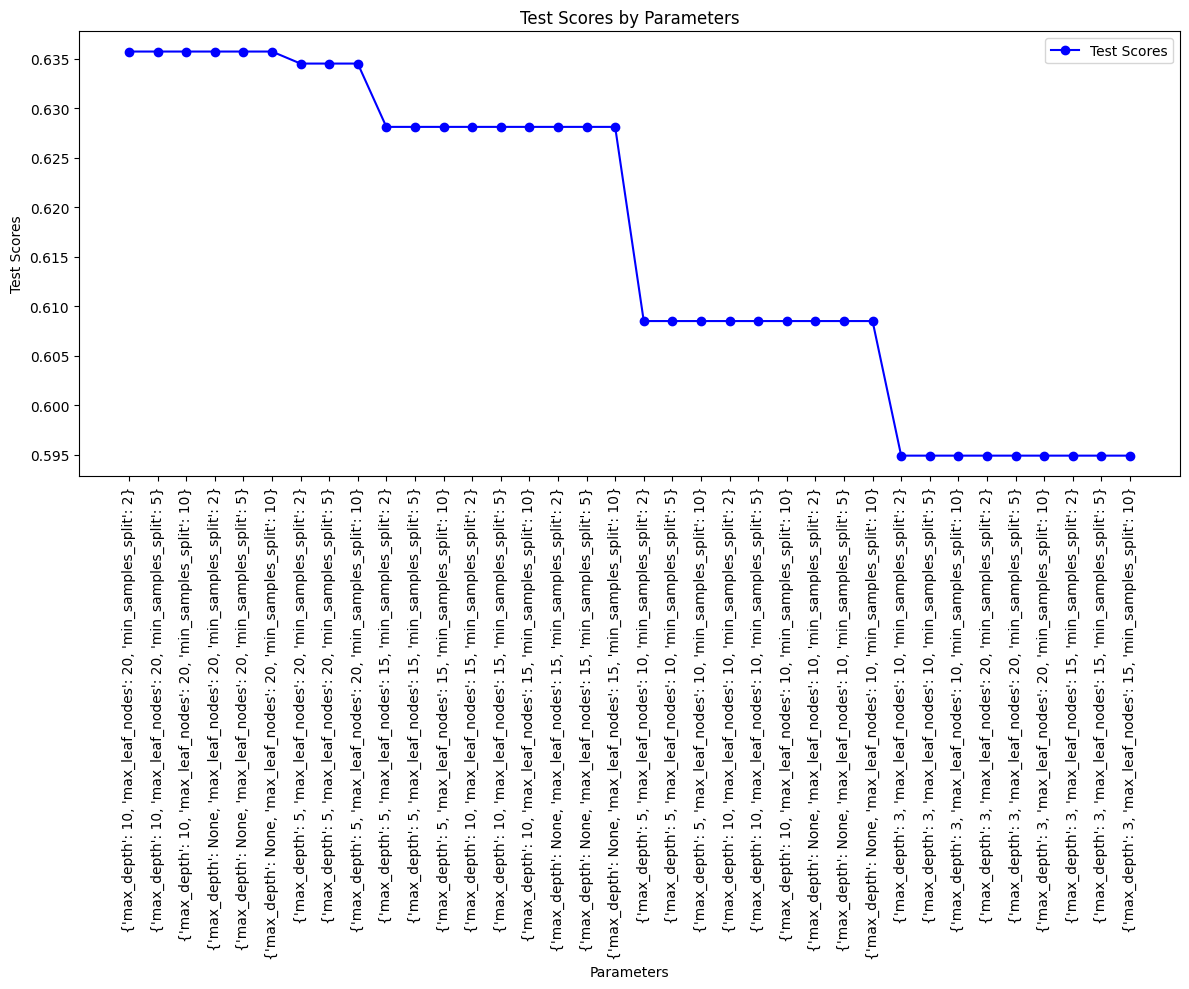

In [147]:
plt.figure(figsize=(12, 10))
plt.plot(
    [param for param, _ in param_test_scores],  # x-axis: parameters
    [score for _, score in param_test_scores],  # y-axis: test_scores
    marker='o', linestyle='-', color='b', label='Test Scores'
)

# Add labels and title
plt.xlabel('Parameters')
plt.ylabel('Test Scores')
plt.title('Test Scores by Parameters')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to fit rotated labels
plt.show()

In [168]:
regression_tree = DecisionTreeRegressor(max_depth=10, min_samples_split=2, max_leaf_nodes=20)
# Train on scaled data
regression_tree.fit(X_train, y_train)

# Predict on the test data
y_pred = regression_tree.predict(X_test)

# Calculate Mean Squared Error as a performance metric
mse = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mse)

Mean Absolute Error: 0.7523686359022038


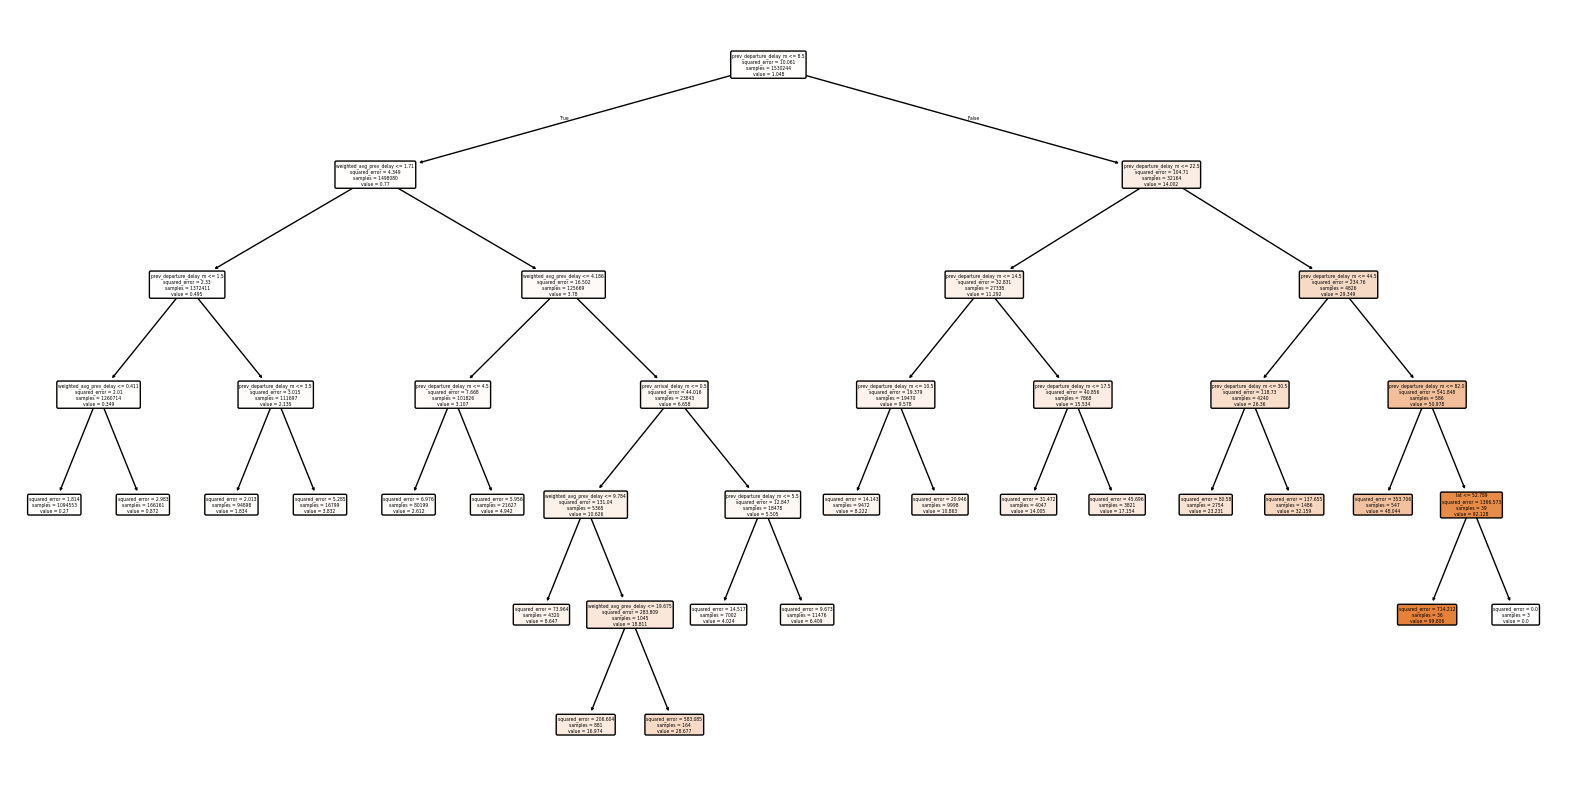

In [169]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assuming 'regressor' is your trained DecisionTreeRegressor
plt.figure(figsize=(20, 10))  # Adjust size as needed for readability
plot_tree(regression_tree, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

# Linear Regression

In [150]:
linear_regressor = LinearRegression()

In [151]:
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)

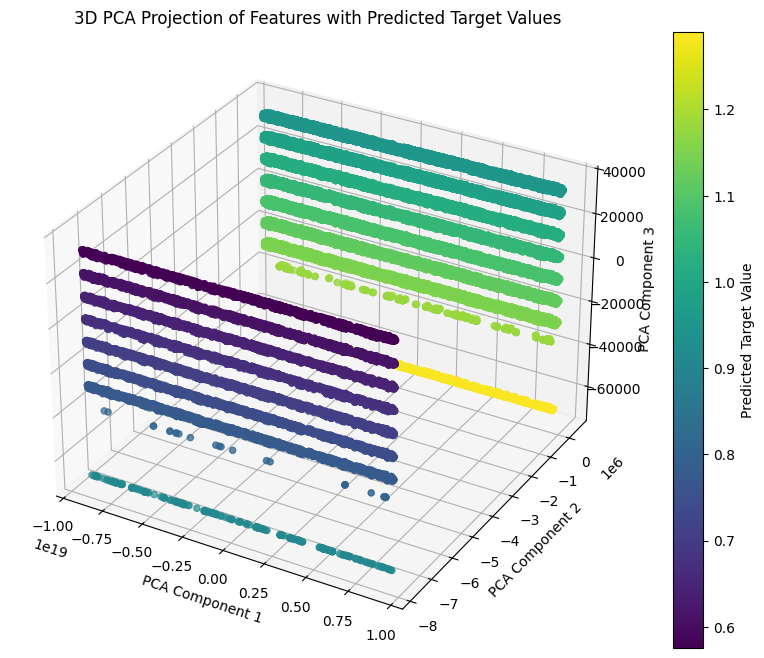

In [152]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
# Apply PCA to reduce the dimensionality to 3 dimensions
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(X_test)

# Create a 3D scatter plot of the reduced features, colored by predicted target values
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=y_pred, cmap='viridis')
fig.colorbar(scatter, label='Predicted Target Value')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('3D PCA Projection of Features with Predicted Target Values')
plt.show()


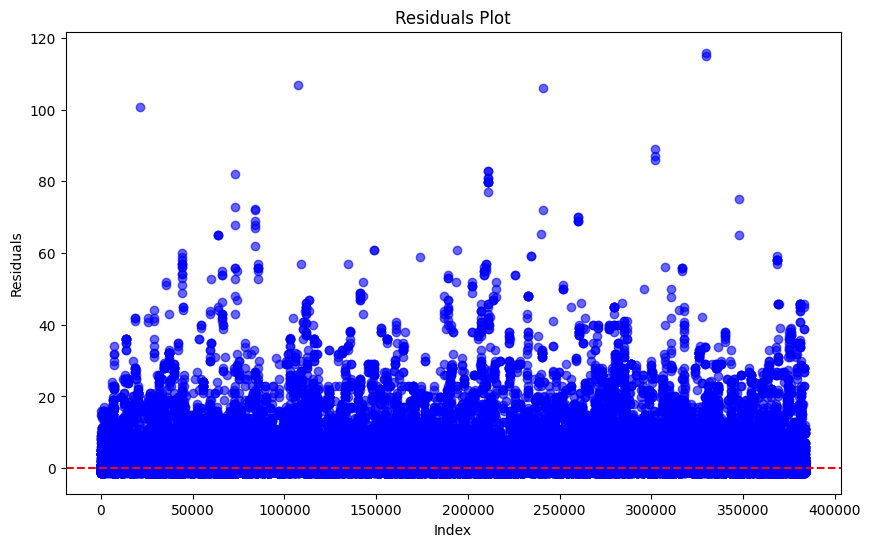

In [153]:
# Assuming you have actual target values (cleaned_target_test)
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, c='b', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [154]:
# Evaluate the model
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mse)
print("R^2 Score:", r2)

Mean Absolute Error: 1.5032701779947677
R^2 Score: 0.0009400824149583542


In [155]:
param_space = {'copy_X': [True,False], 
               'fit_intercept': [True,False], 
               'n_jobs': [1,5,10,15,None], 
               'positive': [True,False]}

In [156]:
grid_search_lr = GridSearchCV(linear_regressor, param_space, cv=5)
grid_search_lr.fit(X_train, y_train) 

/home/tu2/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tu2/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tu2/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tu2/anaconda3/envs/data_mining/lib/

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [1, 5, 10, 15, None],
                         'positive': [True, False]})

In [157]:
results = pd.DataFrame(grid_search_lr.cv_results_)
cv_params = results["params"]
cv_mean_test_score = results["mean_test_score"]
param_test_scores = []

In [158]:
for key in cv_params.keys():
    param = str(cv_params[key])
    score = float(cv_mean_test_score[key])
    target = (param, score)
    param_test_scores.append(target)

In [159]:
param_test_scores = sorted(param_test_scores, key=lambda x: x[1], reverse=True)

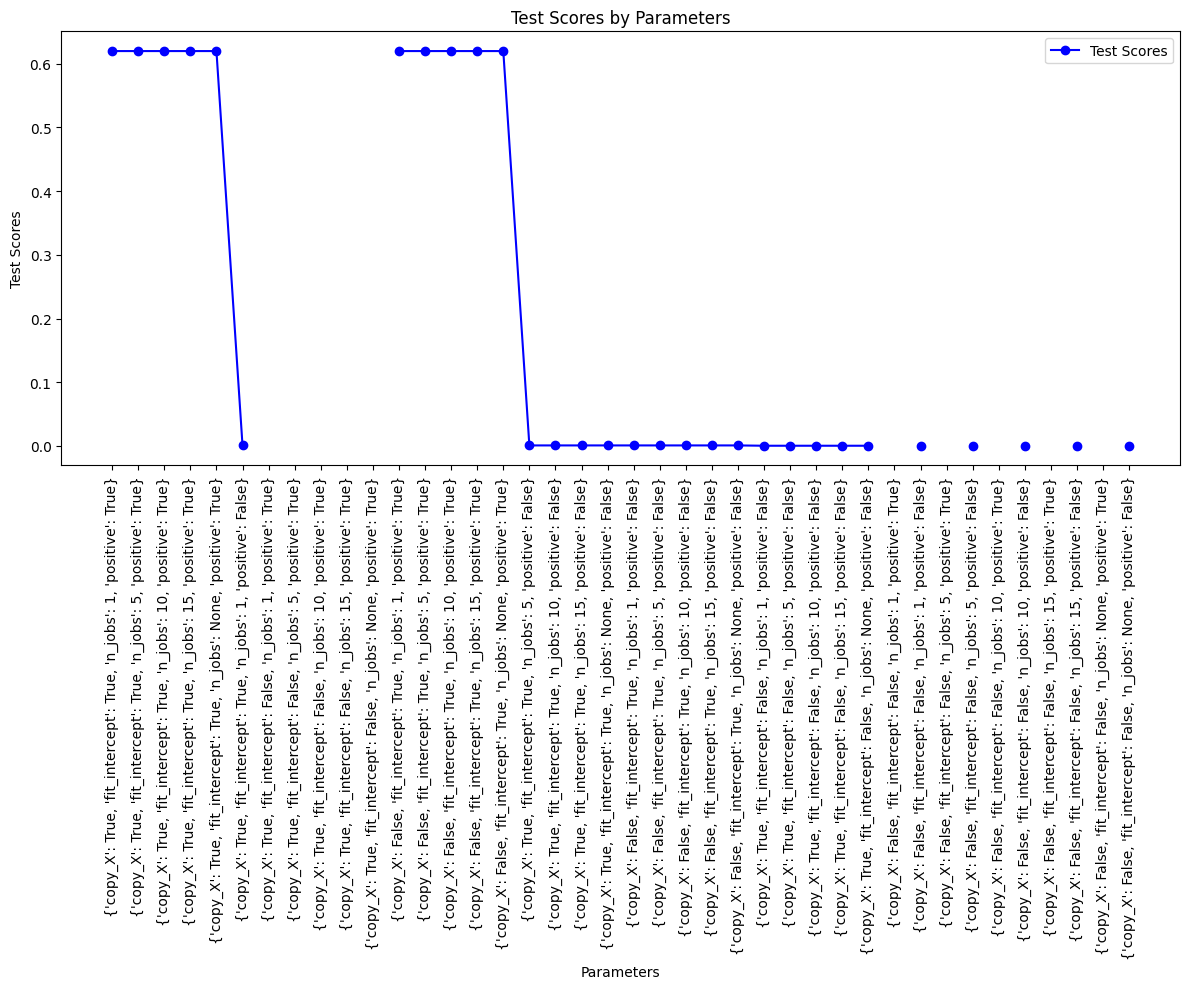

In [160]:
plt.figure(figsize=(12, 10))
plt.plot(
    [param for param, _ in param_test_scores],  # x-axis: parameters
    [score for _, score in param_test_scores],  # y-axis: test_scores
    marker='o', linestyle='-', color='b', label='Test Scores'
)

# Add labels and title
plt.xlabel('Parameters')
plt.ylabel('Test Scores')
plt.title('Test Scores by Parameters')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to fit rotated labels
plt.show()

In [161]:
linear_regressor = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, positive=True)
linear_regressor.fit(X_train, y_train)

LinearRegression(n_jobs=1, positive=True)

In [162]:
y_pred = linear_regressor.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred=y_pred, y_true=y_test)
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 0.723845403120634
R2 Score: 0.5800884366410535
